In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np
from utils import (
    coverage_dowmonth,
    coverage_mthyr,
    save_mpl_fig,
    its, 
    plotline, 
    plot_dual_indices
)
import warnings
warnings.filterwarnings('ignore')

FP1 = '../data/msnbc2003_2014_textstat.csv.gz'
FP2 = '../data/msnbc2010_2021_textstat.csv.gz'
SAVEPATH = '../figs/'
os.makedirs(SAVEPATH, exist_ok=True) 

### Data Coverage

In [2]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP1)
      .assign(date=lambda df: pd.to_datetime(df.Date))
      .pipe(lambda df: pd.concat([df, (pd.read_csv(FP2)
                                       .assign(date=lambda df: pd.to_datetime(df.air_date))
                                      )])
           )
      .groupby(['date']).size().reset_index()      
      .rename(columns={0:'obs'})
      .assign(year=lambda df: [dt64.year for dt64 in df.date])
      .query('year>2002') # only one obs.
     )
df.head(3)

,date,obs,year
1,2003-03-31,7,2003
2,2003-04-01,8,2003
3,2003-04-02,5,2003


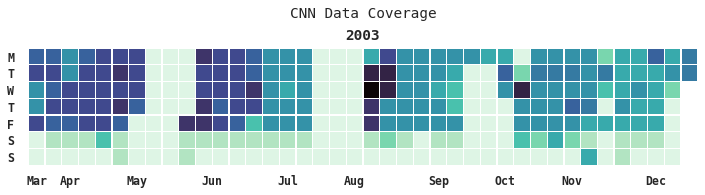

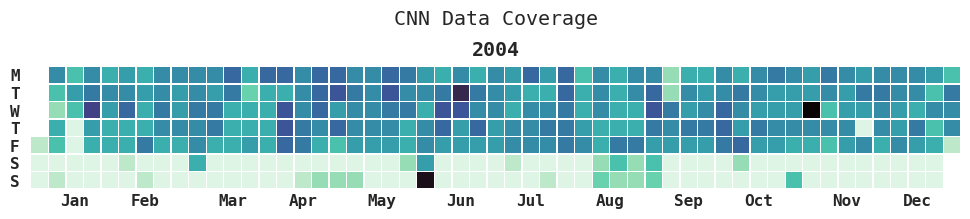

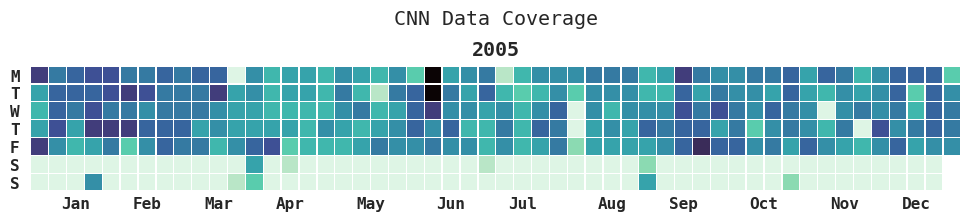

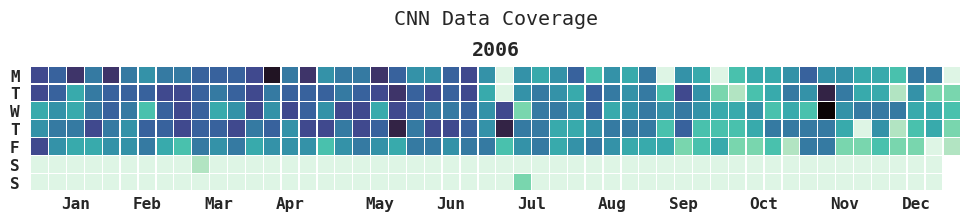

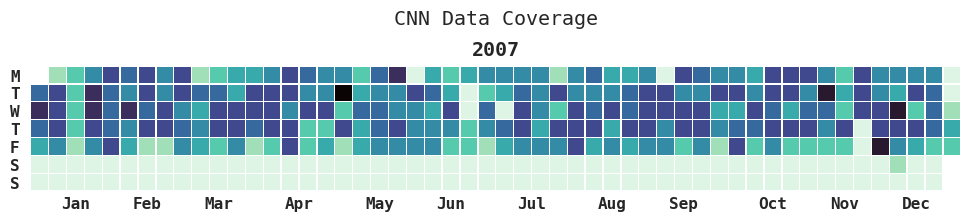

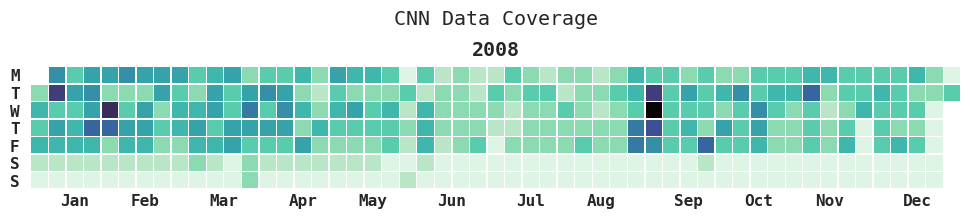

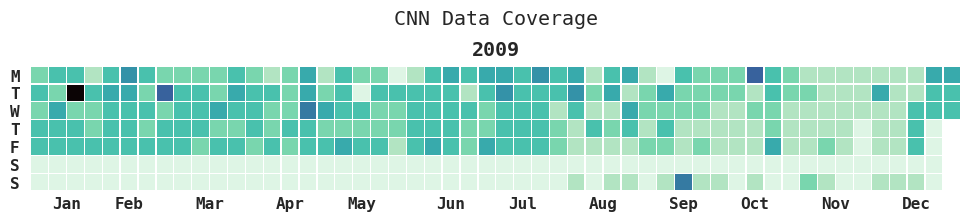

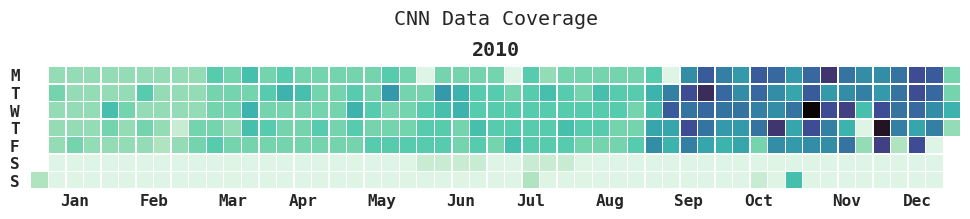

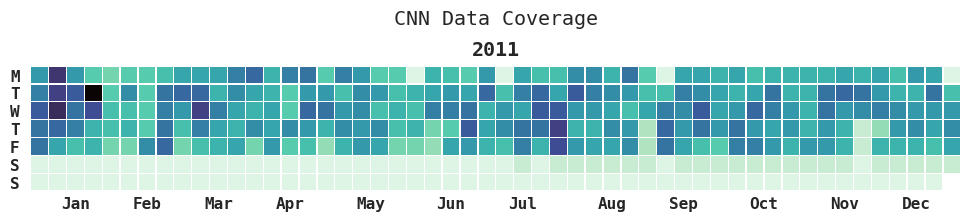

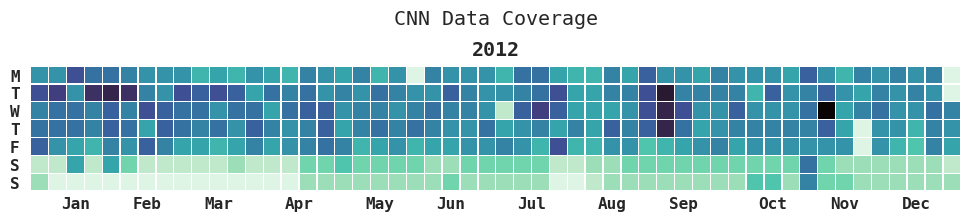

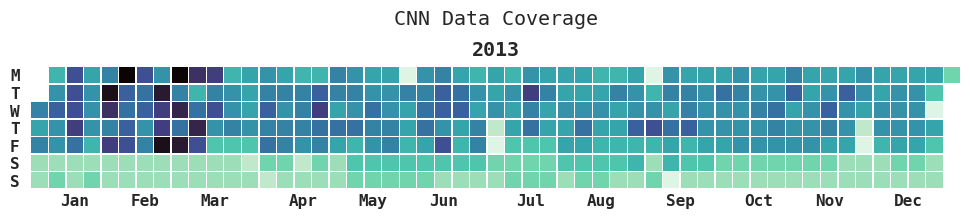

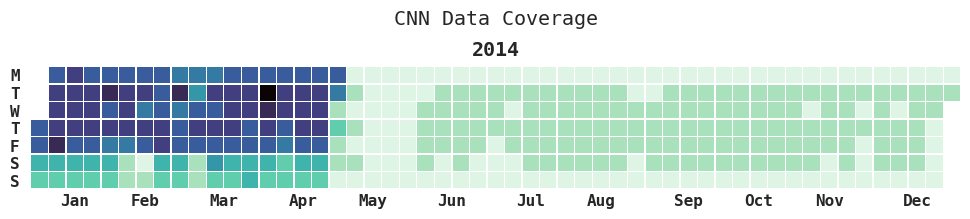

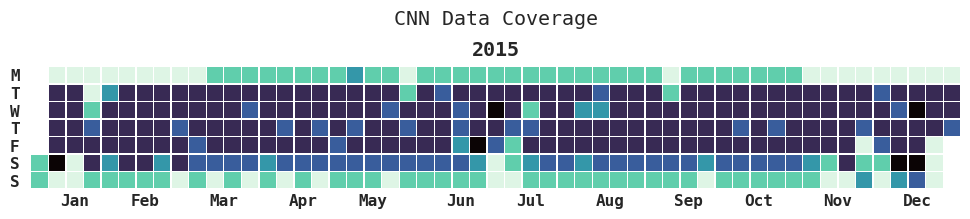

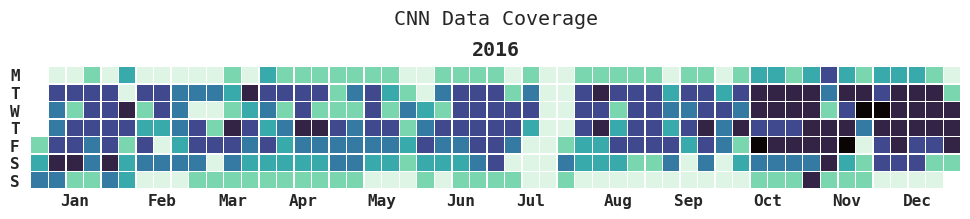

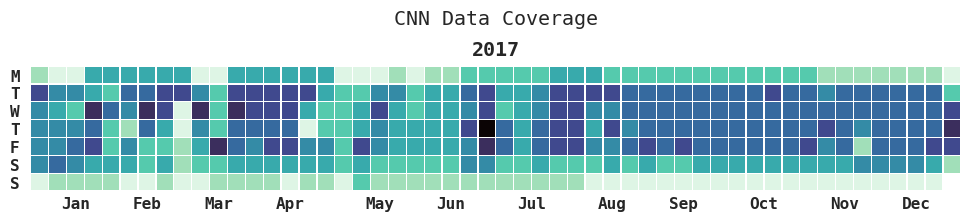

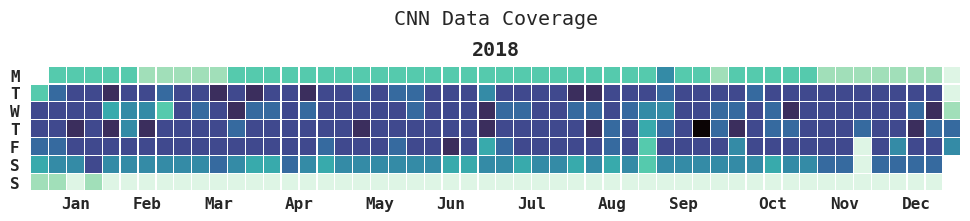

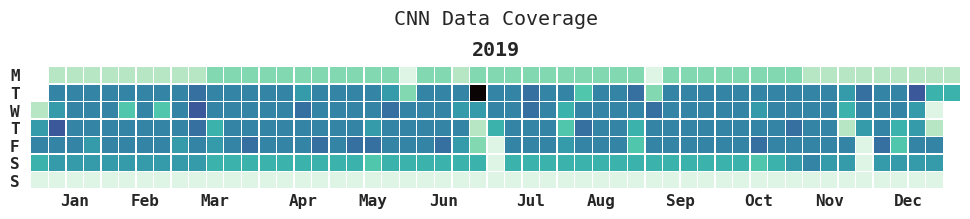

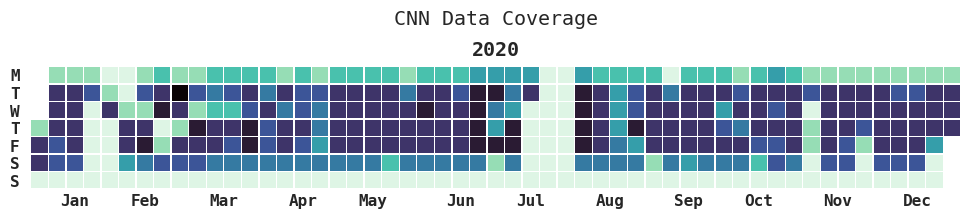

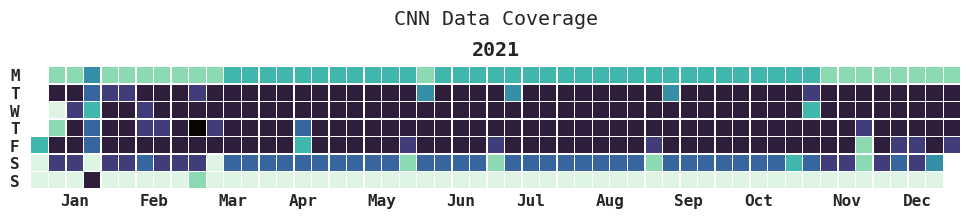

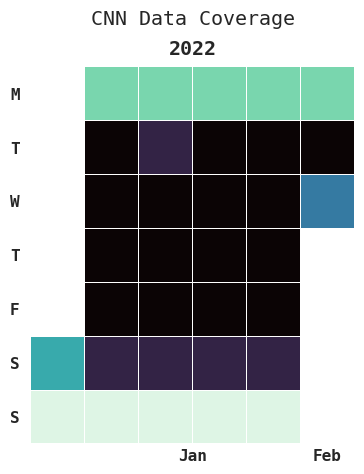

In [3]:
for year in df.year.unique():
    _df = df.query('year==@year')
    coverage_dowmonth(_df.date, _df.obs, title='CNN Data Coverage')
#     save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/msnbc_dowmonth_{year}'))

In [4]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP1)
      .assign(date=lambda df: pd.to_datetime(df.Date))
      .pipe(lambda df: pd.concat([df, (pd.read_csv(FP2)
                                       .assign(date=lambda df: pd.to_datetime(df.air_date))
                                      )])
           )
      .set_index('date').groupby(pd.Grouper(freq='M')).size().reset_index()
      .rename(columns={0: 'count'})
      .assign(month=lambda df: [dt64.month_name()[:3] for dt64 in df.date],
              monthix=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date])
      .pivot(['month', 'monthix'], 'year', 'count')
      .sort_values('monthix').droplevel('monthix')
     )
df.head(3)

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
month,,,,,,,,,,,,,,,,,,,,,
Jan,NaN,0.0,103.0,160.0,136.0,96.0,118.0,62.0,68.0,243.0,208.0,207.0,166.0,68.0,91.0,97.0,128.0,125.0,85.0,102.0,122.0
Feb,NaN,0.0,128.0,151.0,121.0,95.0,82.0,64.0,61.0,145.0,195.0,240.0,138.0,81.0,57.0,90.0,108.0,114.0,88.0,115.0,9.0
Mar,NaN,7.0,150.0,141.0,150.0,89.0,93.0,60.0,98.0,209.0,174.0,188.0,154.0,84.0,69.0,92.0,134.0,132.0,110.0,129.0,NaN


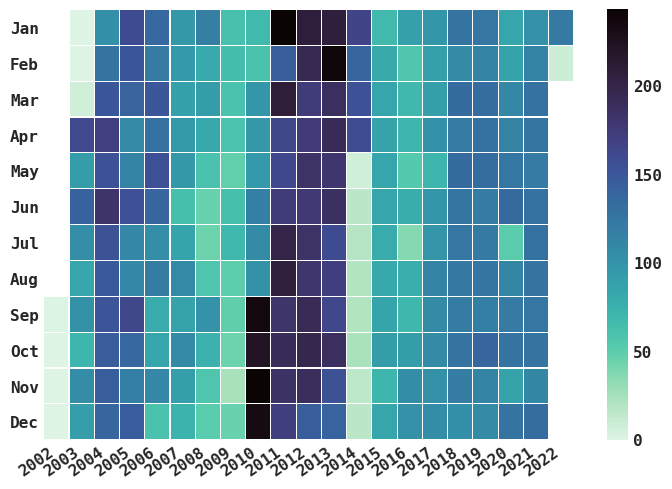

In [5]:
coverage_mthyr(df, xtickangle=35)
save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/msnbc_monthyear'))

### Readability & Lexical Richness

In [6]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP1)
      .assign(date=lambda df: pd.to_datetime(df.Date))
      .pipe(lambda df: pd.concat([df, (pd.read_csv(FP2)
                                       .assign(date=lambda df: pd.to_datetime(df.air_date))
                                      )])
           )
      # set mthyr
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )    
      # Drop outliers by length
      .pipe(lambda df: 
            df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
      .query(f'terms>100') 
      .query('year>2002') # only one obs.
      .groupby(['mthyr']).mean().reset_index()      
     )
df.head(3)

,mthyr,Location(s),Dateline,Length,Estimated printed pages,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,uid,duration,year,month,path,wordcount,subhead
0,2003-03-01,NaN,NaN,8391.857143,25.571429,31.452857,16.000000,13.135714,13.028571,8495.714286,1851.857143,0.201839,61.651502,0.840878,NaN,NaN,2003.0,3.0,NaN,NaN,NaN
1,2003-04-01,NaN,NaN,7540.154321,23.129630,33.238395,15.410494,12.591667,12.589506,7690.401235,1695.327160,0.204584,58.685606,0.839090,NaN,NaN,2003.0,4.0,NaN,NaN,NaN
2,2003-05-01,NaN,NaN,7033.795699,21.591398,33.682366,14.876344,11.859677,12.211828,7235.193548,1648.559140,0.207852,54.048111,0.832537,NaN,NaN,2003.0,5.0,NaN,NaN,NaN


In [7]:
xticklabels=range(2002, 2022, 3)

<AxesSubplot:title={'left':'Word Count per Article'}, xlabel='Publication year'>

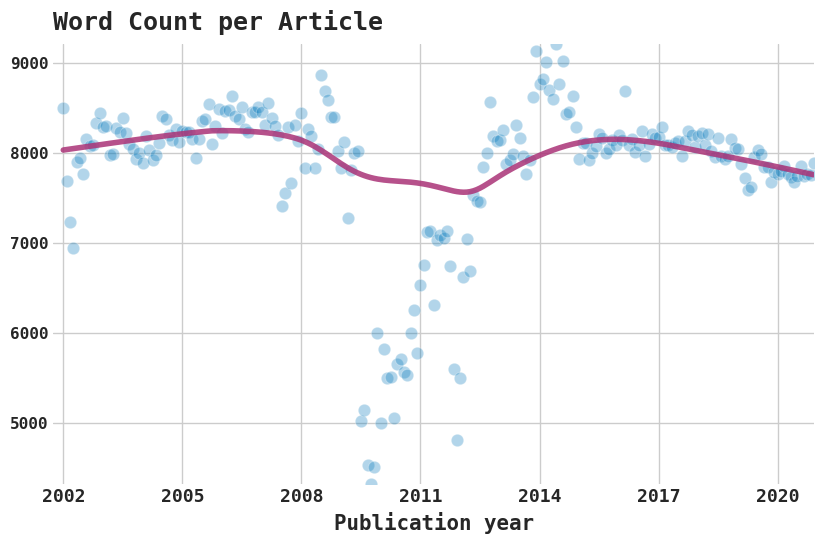

In [8]:
plotline(x=df.index, y=df.terms, xrange=range(0,250,36), xticklabels=xticklabels, 
         title='Word Count per Article', 
         savepath=os.path.join(SAVEPATH, 'msnbc_wordcount')
        )    

<AxesSubplot:title={'left':'Unique Words per Article'}, xlabel='Publication year'>

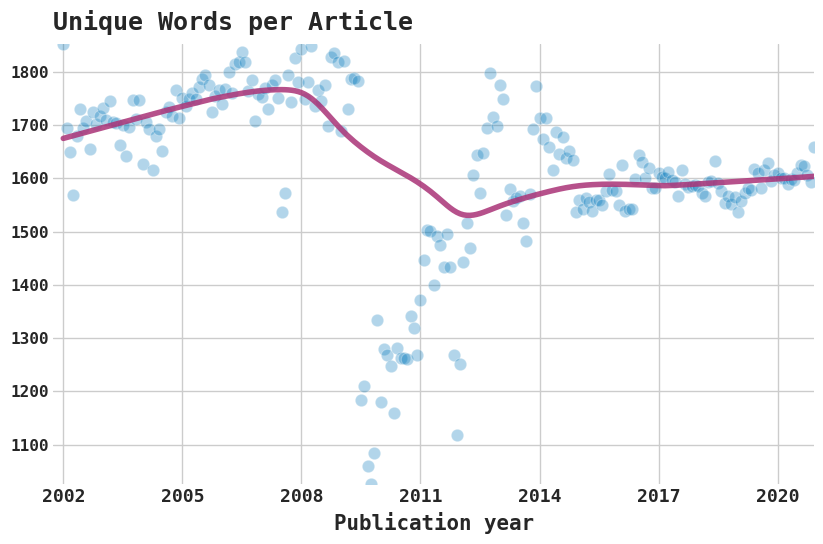

In [9]:
plotline(x=df.index, y=df.uniqueterms, xrange=range(0,250,36), xticklabels=xticklabels, 
         title='Unique Words per Article', 
         savepath=os.path.join(SAVEPATH, 'msnbc_uniquewords')
        ) 

<AxesSubplot:title={'left':'Readability (Flesch Reading Ease)'}, xlabel='Publication year'>

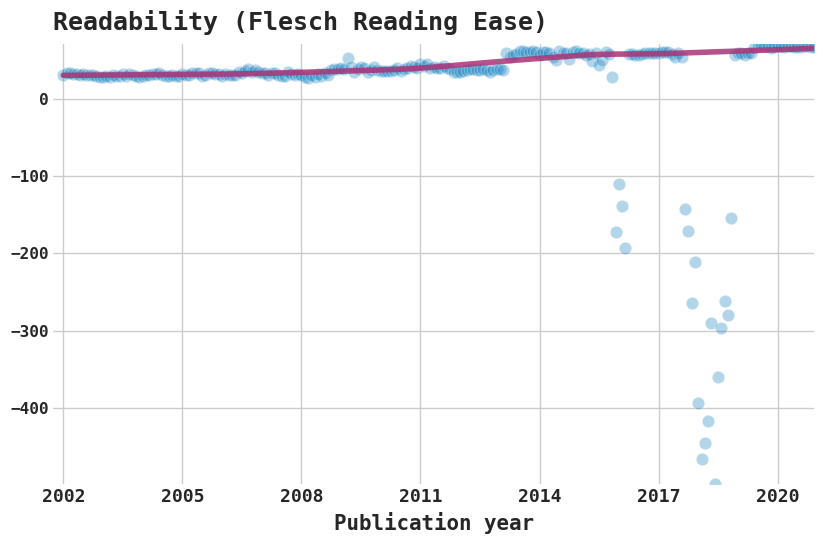

In [10]:
plotline(x=df.index, y=df.flesch_reading_ease, xrange=range(0,250,36), xticklabels=xticklabels, 
         title='Readability (Flesch Reading Ease)',
         savepath=os.path.join(SAVEPATH, 'msnbc_readability_flesch_ease')
        )    

<AxesSubplot:title={'left':'Lexical Richness (MTLD)'}, xlabel='Publication year'>

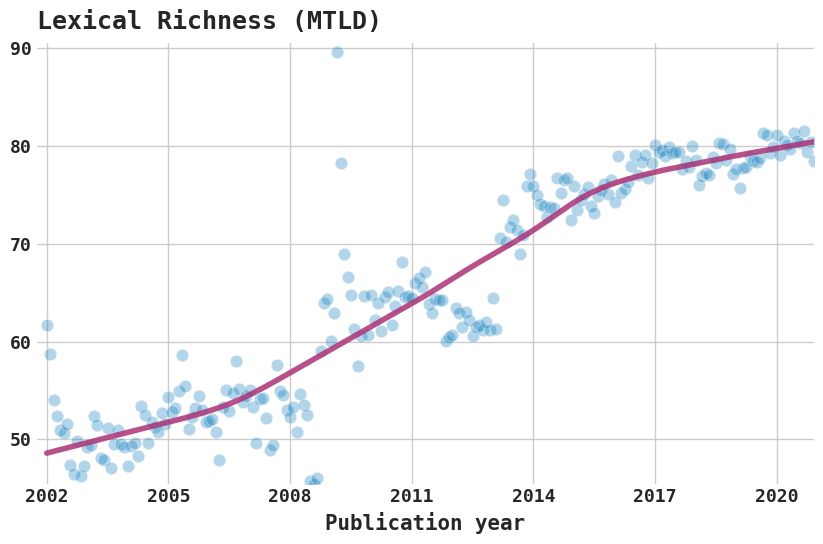

In [11]:
plotline(x=df.index, y=df.mtld, title='Lexical Richness (MTLD)', 
         xrange=range(0,250,36), xticklabels=xticklabels, yrange=range(50,100,10),
         savepath=os.path.join(SAVEPATH, 'msnbc_lexicalrichness_mtld')
        )    

In [12]:
# (fold cell) Prep indices
idf = (pd.read_csv(FP1)
      .assign(date=lambda df: pd.to_datetime(df.Date))
      .pipe(lambda df: pd.concat([df, (pd.read_csv(FP2)
                                       .assign(date=lambda df: pd.to_datetime(df.air_date))
                                      )])
           )
      # set mthyr
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )    
      # Drop outliers by length
      .pipe(lambda df: 
            df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
      .query(f'terms>100')
      .query('year>2002') # only one obs.
      .groupby(['year']).mean().reset_index()
      .assign(
          iflesch_reading_ease=lambda df: df.apply(its, base=df.loc[0,'flesch_reading_ease'], x='flesch_reading_ease', axis=1),
          ismog=lambda df: df.apply(its, base=df.loc[0,'smog'], x='smog', axis=1),
          imtld=lambda df: df.apply(its, base=df.loc[0,'mtld'], x='mtld', axis=1),
          ittr=lambda df: df.apply(its, base=df.loc[0,'ttr'], x='ttr', axis=1),
          iword=lambda df: df.apply(its, base=df.loc[0,'terms'], x='terms', axis=1),
          iuniqueterms=lambda df: df.apply(its, base=df.loc[0,'uniqueterms'], x='uniqueterms', axis=1),
             )
     )
idf.head(3)

,year,Location(s),Dateline,Length,Estimated printed pages,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,uid,duration,month,path,wordcount,subhead,iflesch_reading_ease,ismog,imtld,ittr,iword,iuniqueterms
0,2003,NaN,NaN,7482.264523,22.942946,32.135239,15.135685,11.866234,12.234440,7708.214730,1673.973029,0.196437,52.010572,0.830684,NaN,NaN,7.562241,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2004,NaN,NaN,7926.742614,24.272159,30.429278,15.574489,12.130375,12.296761,8205.815341,1705.377841,0.186496,49.401894,0.825665,NaN,NaN,6.598295,NaN,NaN,NaN,-5.308690,0.509394,-5.015670,-5.060496,6.455459,1.876064
2,2005,NaN,NaN,7834.958955,24.015547,30.818831,15.533706,12.154353,12.304789,8096.281095,1690.238806,0.186809,50.098147,0.827515,NaN,NaN,6.425373,NaN,NaN,NaN,-4.096462,0.575006,-3.676993,-4.901209,5.034452,0.971687


<AxesSubplot:xlabel='Publication year', ylabel='Percentage change from 1987'>

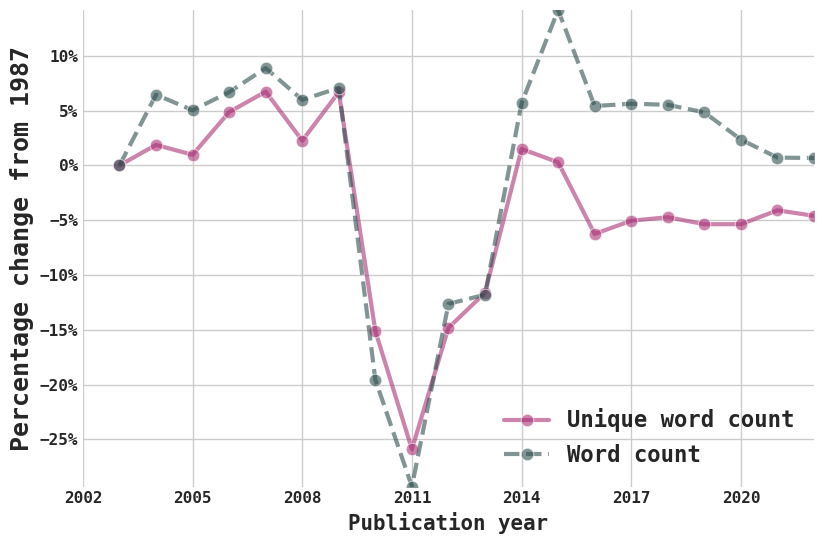

In [13]:
plot_dual_indices(x=idf.year, y1=idf.iuniqueterms, y2=idf.iword, xrange=range(2002,2022,3),
                  label1='Unique word count', label2='Word count', title='',
                  savepath=os.path.join(SAVEPATH, 'msnbc_words_uniquewords')
                 )    

<AxesSubplot:title={'left':'Readability'}, xlabel='Publication year', ylabel='Percentage change from 1987'>

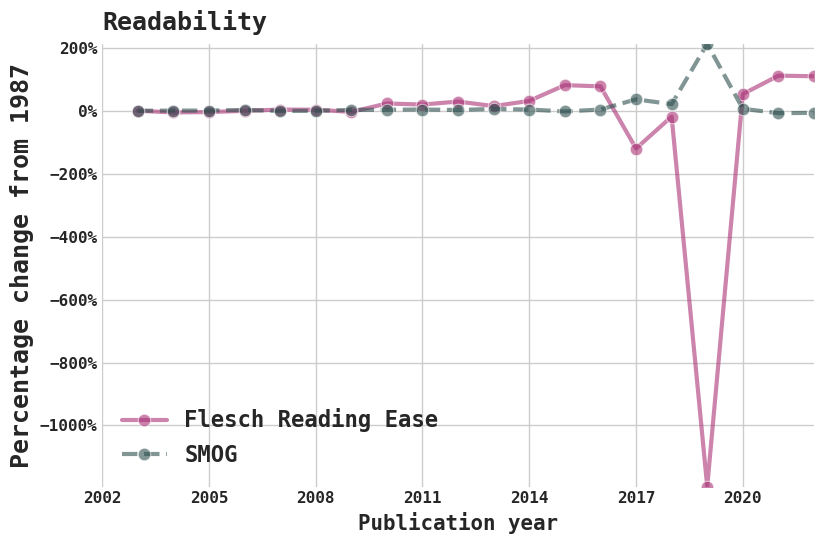

In [14]:
plot_dual_indices(x=idf.year, y1=idf.iflesch_reading_ease, y2=idf.ismog, xrange=range(2002,2022,3),
                  label1='Flesch Reading Ease', label2='SMOG', title='Readability',
                  savepath=os.path.join(SAVEPATH, 'msnbc_readability_index')
                 )    

<AxesSubplot:title={'left':'Lexical Richness'}, xlabel='Publication year', ylabel='Percentage change from 1987'>

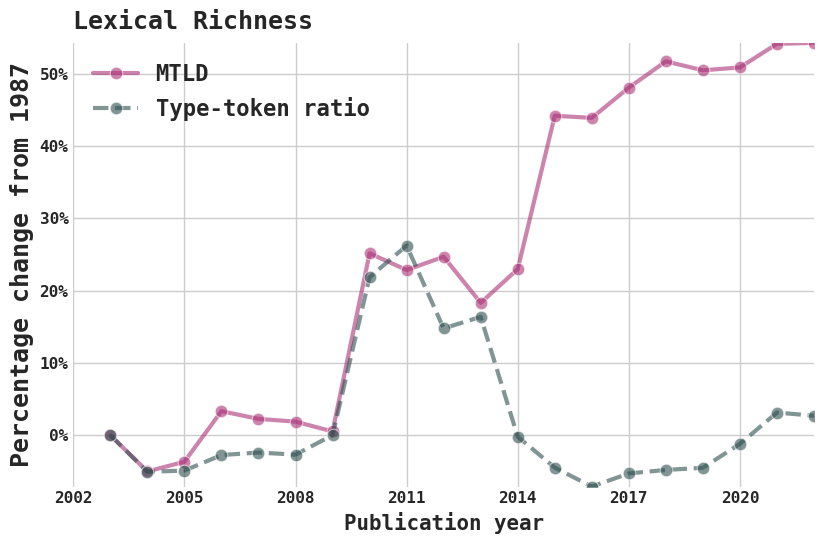

In [15]:
plot_dual_indices(x=idf.year, y1=idf.imtld, y2=idf.ittr, xrange=range(2002,2022,3),
                  label1='MTLD', label2='Type-token ratio', title='Lexical Richness', 
                  savepath=os.path.join(SAVEPATH, 'msnbc_lexicalrichness_index')
                 )    